# Correlation Summary

In [1]:
import cooler
import numpy as np
import pandas as pd
from scipy.sparse import triu
from scipy.stats import pearsonr, zscore, norm
from multiprocessing import Pool
from concurrent.futures import ProcessPoolExecutor, as_completed
from ALLCools.mcds import MCDS
from ALLCools.mcds.utilities import calculate_posterior_mc_frac
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm as cm
import seaborn as sns

mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'


all [0.307 0.382 0.488 0.519 0.322 0.506 0.568 0.531 0.648 0.764 0.736 0.463
 0.727 0.722] [711, 1386, 1090, 2331, 295078, 86626, 312990, 69, 396, 96, 460, 14306, 12718, 99281]


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


neu [0.224 0.371 0.369 0.471 0.3   0.506 0.564 0.619 0.694 0.812 0.744 0.467
 0.733 0.714] [619, 1259, 710, 1716, 168938, 56027, 247125, 55, 343, 84, 417, 6684, 9303, 81904]


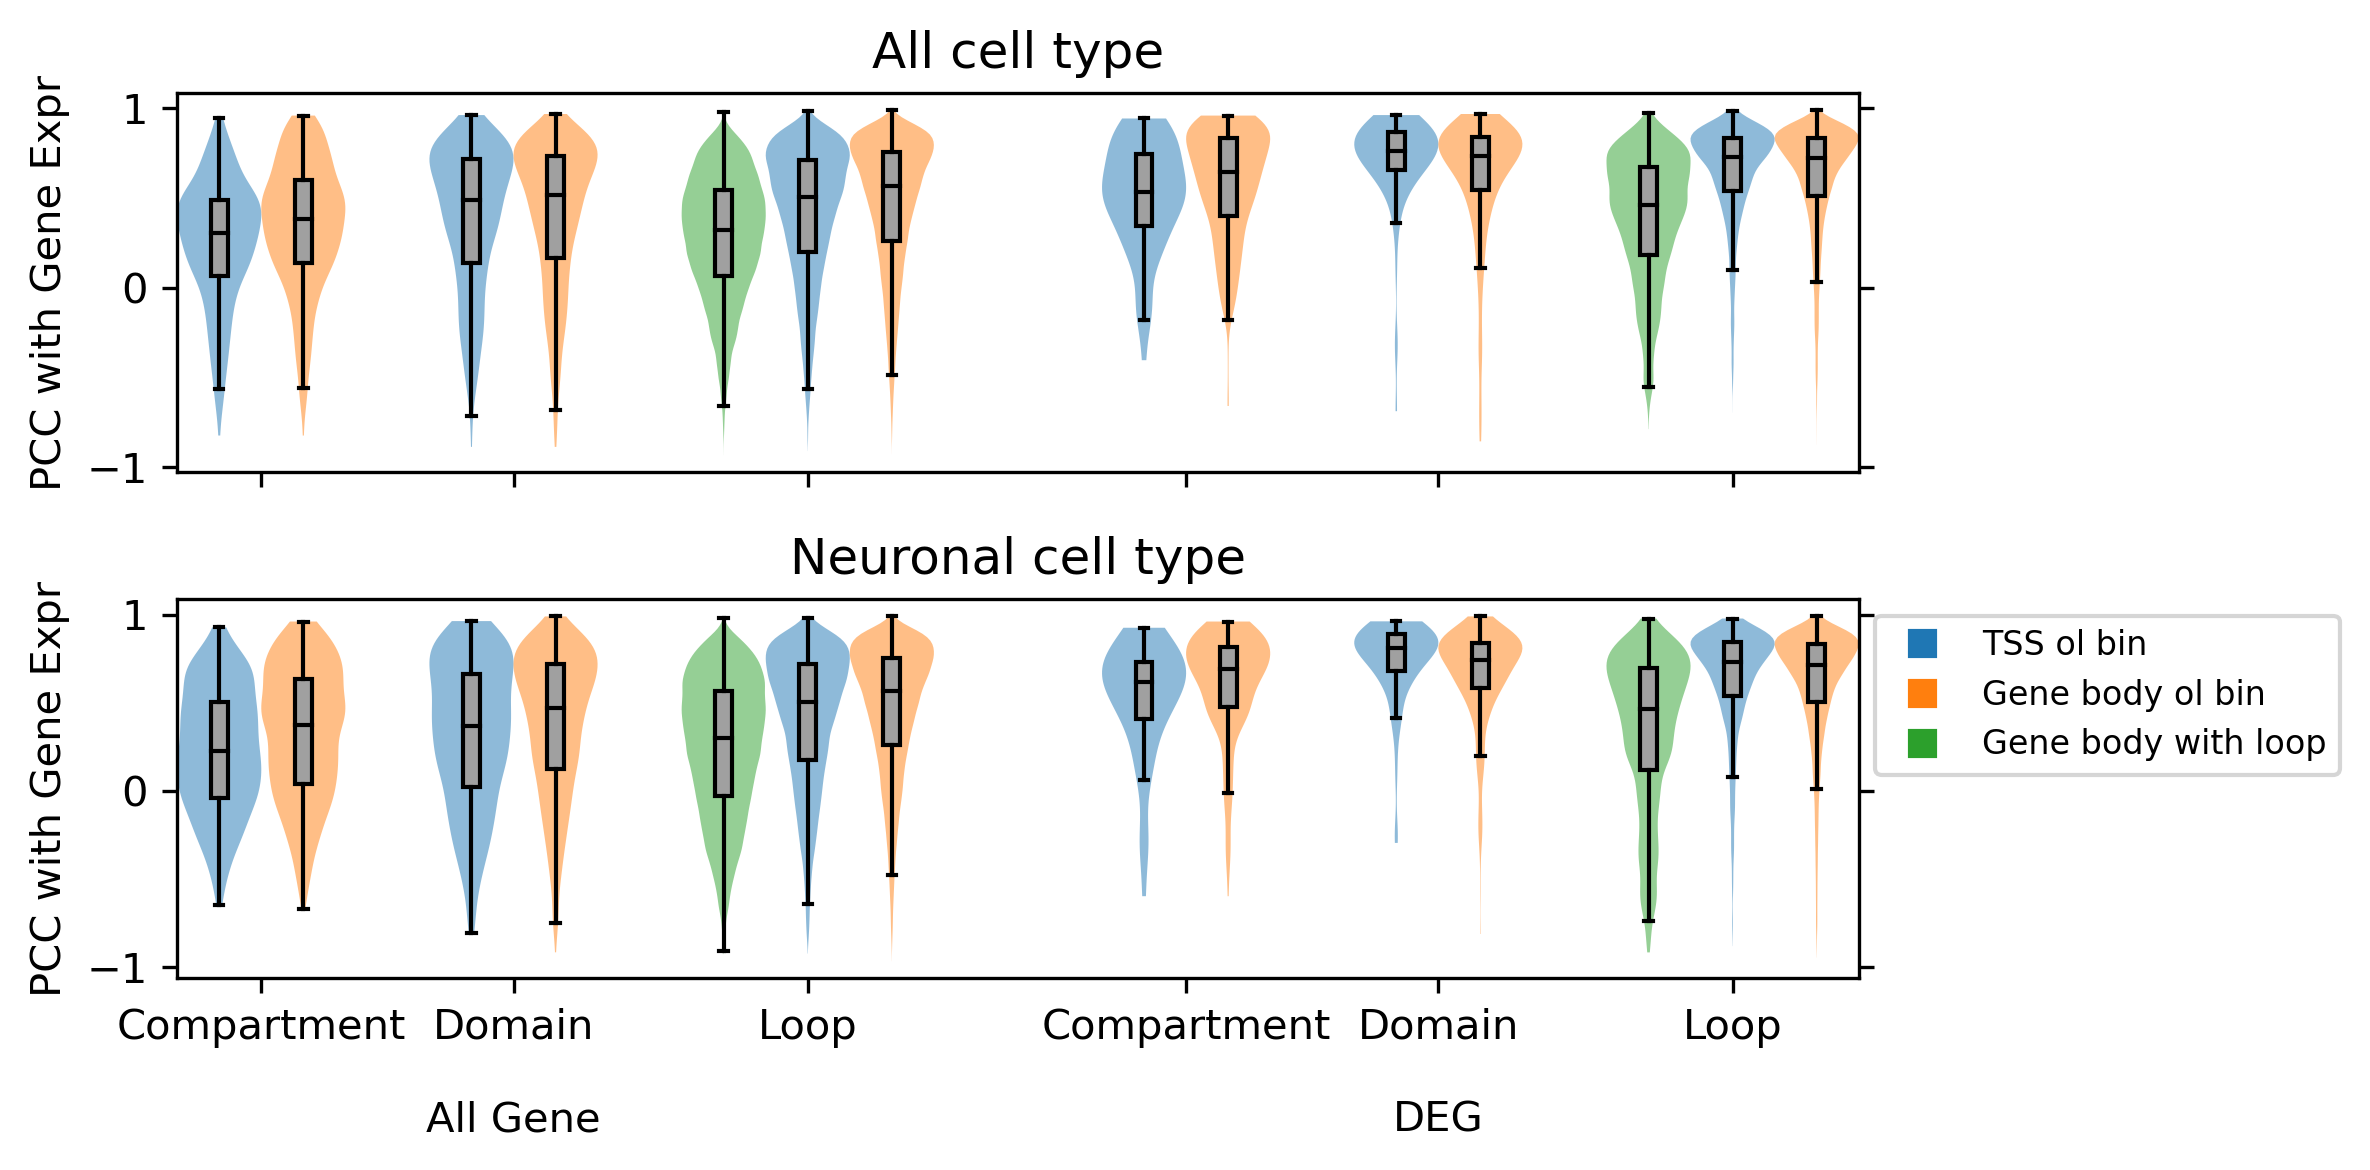

In [3]:
xpos = [0,1,3,4,6,7,8,11,12,14,15,17,18,19]
color = ['C0', 'C1', 'C0', 'C1', 'C2', 'C0', 'C1', 'C0', 'C1', 'C0', 'C1', 'C2', 'C0', 'C1']

fig, axes = plt.subplots(2, 1, figsize=(8,4), dpi=300, sharex='all')
for i,group in enumerate(['all', 'neu']):
    ax = axes[i]
    
    corr_all = []
    corr_all += np.load(f'compartment_majortype/diff/{group}/corr_diffloop_rna.npy', allow_pickle=True)[[0,2,1,3]].tolist()
    corr_all += np.load(f'domain_majortype/diff/{group}/corr_diffbound_rna.npy', allow_pickle=True)[[0,2,1,3]].tolist()
    corr_all += np.load(f'loop_majortype/diff/{group}/corr_diffloop_rna.npy', allow_pickle=True)[[0,2,4,1,3,5]].tolist()
    corr_all = np.array(corr_all)[[0,1,4,5,8,9,10,2,3,6,7,11,12,13]]

    plot = ax.violinplot(dataset=corr_all, positions=xpos, widths=1, showextrema=False, bw_method='scott')
    for p, c in zip(plot['bodies'], color):
        p.set_facecolor(c)
        p.set_alpha(0.5)

    plot = ax.boxplot(corr_all, positions=xpos, showfliers=False, widths=0.2, patch_artist=True, medianprops={'color':'k'})
    for p in plot['boxes']:
        p.set_facecolor('#a0a0a0')

    ax.set_ylabel('PCC with Gene Expr')
    ax.set_title(['All cell type', 'Neuronal cell type'][i], fontsize=12)
    ax.tick_params(left=True, right=True)
    
    print(group, np.around([np.median(xx) for xx in corr_all], decimals=3), [len(xx) for xx in corr_all])
    
ax.set_xticks([0.5, 3.5, 7, 11.5, 14.5, 18])
ax.set_xticklabels(['Compartment', 'Domain\n\nAll Gene', 'Loop', 'Compartment', 'Domain\n\nDEG', 'Loop'])

markers = [
    plt.Line2D([0, 0], [0, 0], color=color, marker="s", linestyle="")
    for color in ['C0','C1','C2']
]

ax.legend(
    markers, ['TSS ol bin', 'Gene body ol bin', 'Gene body with loop'], fontsize=8, numpoints=1, bbox_to_anchor=(1, 1), loc="upper left"
)

plt.tight_layout()
# plt.savefig('RNA_corr.pdf', transparent=True)


In [7]:
from scipy.stats import ranksums

In [10]:
print(ranksums(corr_all[4], corr_all[6]), ranksums(corr_all[11], corr_all[13]))

RanksumsResult(statistic=-188.0559066053279, pvalue=0.0) RanksumsResult(statistic=-54.823812941282505, pvalue=0.0)


In [4]:
mch_corr, mcg_corr, atac_corr = [], [], []
for group in ['all', 'neu']:
    filelist = [f'compartment_majortype/diff/{group}/bin_stats.hdf', 
                f'domain_majortype/diff/{group}/bin_stats.hdf', 
                f'loop_majortype/diff/{group}/merged_loop.hdf']
    for i,file in enumerate(filelist):
        tmp = pd.read_hdf(file)
        if i==0:
            selb = zscore(tmp['sample_maha'])>norm.isf(0.025)
        elif i==1:
            selb = (tmp['chi2filter'] & tmp['diff_sc'] & tmp['bklfilter'] & tmp['ins_lm'] & (tmp['probdiff']>0.05))
        else:
            selb = ((zscore(tmp['Qanova'])>norm.isf(0.15)) & (zscore(tmp['Tanova'])>norm.isf(0.15)))
        nanfilter = (tmp[['mCG_corr', 'mCH_corr', 'ATAC_corr']].isna().sum(axis=1)==0)
        tmp = tmp.loc[selb & nanfilter, ['mCG_corr', 'mCH_corr', 'ATAC_corr']].T.values.tolist()
        mcg_corr.append(tmp[0])
        mch_corr.append(tmp[1])
        atac_corr.append(tmp[2])


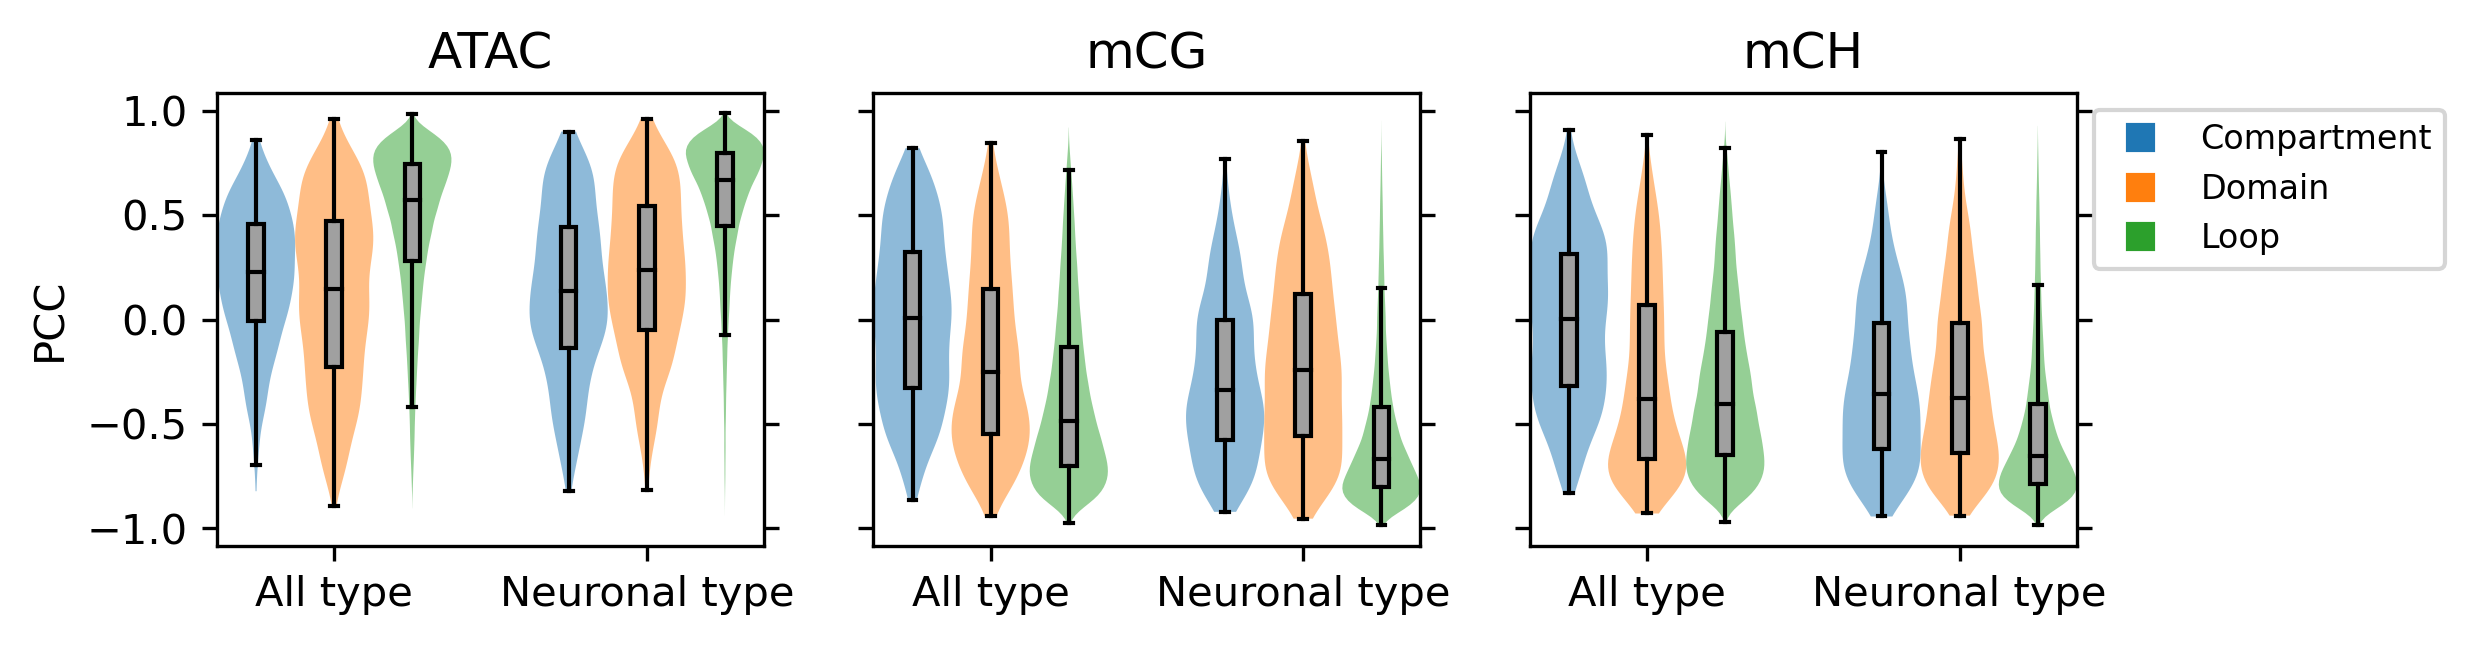

In [5]:
xpos = [0,1,2,4,5,6]
color = ['C0', 'C1', 'C2', 'C0', 'C1', 'C2']

fig, axes = plt.subplots(1, 3, figsize=(8,2), dpi=300, sharex='all', sharey='all')

for i,corr in enumerate([atac_corr, mcg_corr, mch_corr]):
    ax = axes[i]
    plot = ax.violinplot(dataset=corr, positions=xpos, widths=1, showextrema=False, bw_method='scott')
    for p, c in zip(plot['bodies'], color):
        p.set_facecolor(c)
        p.set_alpha(0.5)

    plot = ax.boxplot(corr, positions=xpos, showfliers=False, widths=0.2, patch_artist=True, medianprops={'color':'k'})
    for p in plot['boxes']:
        p.set_facecolor('#a0a0a0')

    ax.set_title(['ATAC', 'mCG', 'mCH'][i], fontsize=12)
    ax.tick_params(left=True, right=True)
    
ax.set_xticks([1,5])
ax.set_xticklabels(['All type', 'Neuronal type'])
axes[0].set_ylabel('PCC')

markers = [
    plt.Line2D([0, 0], [0, 0], color=color, marker="s", linestyle="")
    for color in ['C0','C1','C2']
]

ax.legend(
    markers, ['Compartment', 'Domain', 'Loop'], fontsize=8, numpoints=1, bbox_to_anchor=(1, 1), loc="upper left"
)

# plt.tight_layout()
# plt.savefig('Epi_corr.pdf', transparent=True)
    

In [6]:
for i,corr in enumerate([atac_corr, mcg_corr, mch_corr]):
    print(i, np.around([np.median(xx) for xx in corr], decimals=3), [len(xx) for xx in corr])
    

0 [0.23  0.146 0.574 0.139 0.24  0.668] [1188, 2047, 173615, 1024, 1716, 148250]
1 [ 0.006 -0.252 -0.487 -0.339 -0.24  -0.667] [1188, 2047, 173615, 1024, 1716, 148250]
2 [ 0.001 -0.382 -0.405 -0.357 -0.376 -0.655] [1188, 2047, 173615, 1024, 1716, 148250]


In [2]:
from glob import glob

gene_list = np.sort(glob('rna_majortype/gene_*poscorr*'))
gene_list

array(['rna_majortype/gene_boundposcorr_genebody.csv.gz',
       'rna_majortype/gene_boundposcorr_tes.csv.gz',
       'rna_majortype/gene_boundposcorr_tss.csv.gz',
       'rna_majortype/gene_boundposcorr_tsstes.csv.gz',
       'rna_majortype/gene_compposcorr_genebody.csv.gz',
       'rna_majortype/gene_loopposcorr_genebodyboth.csv.gz',
       'rna_majortype/gene_loopposcorr_genebodyone.csv.gz',
       'rna_majortype/gene_loopposcorr_tes.csv.gz',
       'rna_majortype/gene_loopposcorr_tss.csv.gz'], dtype='<U50')

In [3]:
gene_list = [gene_list[i] for i in [0,1,2,3,4,5,7,8]]
geneall = [pd.read_csv(xx, index_col=0, header=None).index for xx in gene_list]


In [4]:
comp_gene = pd.Index(np.unique(np.concatenate([geneall[i] for i in [4]])))
domain_gene = pd.Index(np.unique(np.concatenate([geneall[i] for i in [0,1,2,3]])))
loop_gene = pd.Index(np.unique(np.concatenate([geneall[i] for i in [5,6,7]])))


In [5]:
print([xx.shape[0] for xx in geneall])
geneall = np.unique(np.concatenate(geneall))

print(geneall.shape[0], geneall.shape[0]/1099)

[591, 271, 285, 466, 450, 898, 877, 962]
1064 0.9681528662420382


In [6]:
from matplotlib_venn import venn3

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


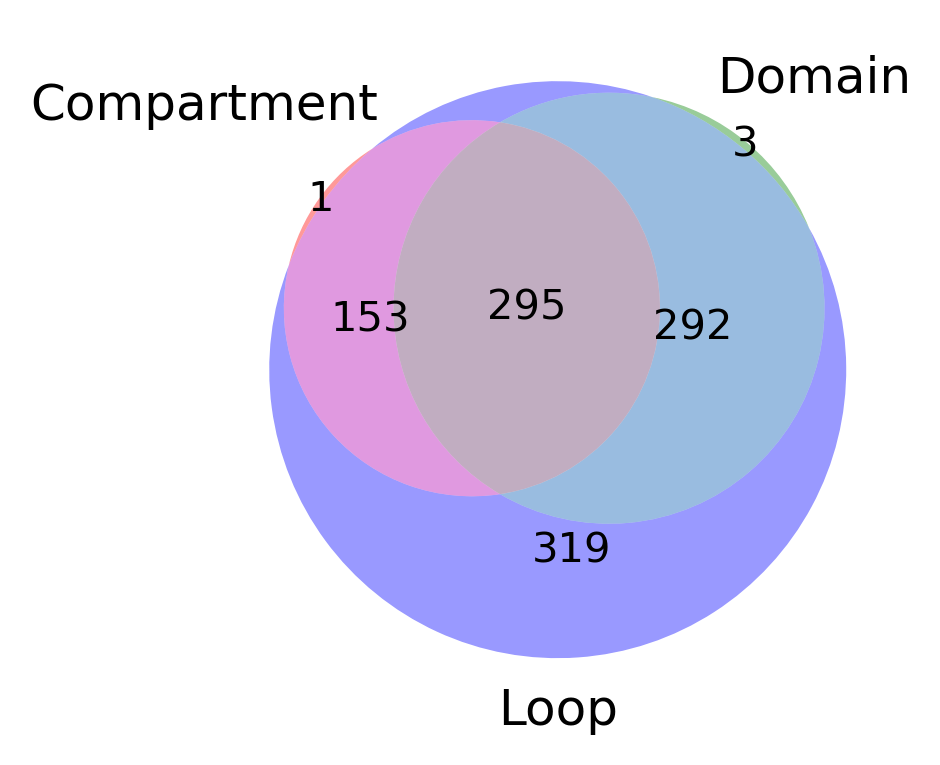

In [7]:
fig, ax = plt.subplots(figsize=(3,3), dpi=300)
plot = venn3(subsets=[set(comp_gene), set(domain_gene), set(loop_gene)], set_labels = ('Compartment', 'Domain', 'Loop'), ax=ax)
# plt.savefig('DEG_corr_3d_venn.pdf', transparent=True)
